<a href="https://colab.research.google.com/github/Cromana22/Google-Colab-Examples/blob/main/PrebuiltAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cohere

**Imports and Global Settings**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cohere
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sns.set(style="whitegrid")
np.random.seed(42)

In [13]:
# Number of customers per cluster
n_customers = 125

# Cluster 0: Budget Family Shopper
cluster_0 = pd.DataFrame({
    'grocery_spend': np.random.normal(100, 40, n_customers),
    'electronics_spend': np.random.normal(50, 20, n_customers),
    'clothing_spend': np.random.normal(60, 25, n_customers),
    'beauty_spend': np.random.normal(40, 15, n_customers),
    'visits_per_month': np.random.normal(6, 3, n_customers),
    'avg_basket_size': np.random.normal(40, 10, n_customers),
    'cluster': 0
})

# Cluster 1: Tech Enthusiast
cluster_1 = pd.DataFrame({
    'grocery_spend': np.random.normal(100, 25, n_customers),
    'electronics_spend': np.random.normal(500, 60, n_customers),
    'clothing_spend': np.random.normal(100, 30, n_customers),
    'beauty_spend': np.random.normal(70, 20, n_customers),
    'visits_per_month': np.random.normal(6, 2, n_customers),
    'avg_basket_size': np.random.normal(120, 20, n_customers),
    'cluster': 1
})

# Cluster 2: Fashion & Beauty Lover
cluster_2 = pd.DataFrame({
    'grocery_spend': np.random.normal(100, 30, n_customers),
    'electronics_spend': np.random.normal(80, 25, n_customers),
    'clothing_spend': np.random.normal(500, 60, n_customers),
    'beauty_spend': np.random.normal(500, 50, n_customers),
    'visits_per_month': np.random.normal(6, 2, n_customers),
    'avg_basket_size': np.random.normal(100, 15, n_customers),
    'cluster': 2
})

# Cluster 3: High-End Bulk Shopper
cluster_3 = pd.DataFrame({
    'grocery_spend': np.random.normal(400, 50, n_customers),
    'electronics_spend': np.random.normal(300, 70, n_customers),
    'clothing_spend': np.random.normal(350, 50, n_customers),
    'beauty_spend': np.random.normal(300, 40, n_customers),
    'visits_per_month': np.random.normal(3, 1, n_customers),
    'avg_basket_size': np.random.normal(400, 30, n_customers),
    'cluster': 3
})

# Combine all clusters
data = pd.concat([cluster_0, cluster_1, cluster_2, cluster_3], ignore_index=True)

# Shuffle
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data['customer_id'] = np.arange(1, len(data) + 1)

# Save CSV
data.to_csv("sample_customer_data.csv", index=False)


**Import Data**

In [14]:
data = pd.read_csv("sample_customer_data.csv")
data = pd.DataFrame(data)
print("Sample Customer Data:")
print(data.head())

Sample Customer Data:
   grocery_spend  electronics_spend  clothing_spend  beauty_spend  \
0      39.402180          60.227955      450.433280    488.947877   
1     165.274276          42.553619       66.449400     34.184501   
2     110.687584          82.445332      463.519631    457.596720   
3      96.241988         480.678311      125.866705     65.657379   
4      70.815901          49.219610       45.154715     60.795241   

   visits_per_month  avg_basket_size  cluster  customer_id  
0         11.078763        79.032918        2            1  
1          6.582156        49.331281        0            2  
2          7.378329       106.358342        2            3  
3         10.186396       136.937642        1            4  
4          8.346390        16.838561        0            5  


**Preprocess Data via Scaling**

In [15]:
features = data.drop(columns=['customer_id'])       # We don't need the ID for looking at the data.
scaler = StandardScaler()                           # Scaling by removing the average. It brings numbers closer together for ease of processing.
scaled_features = scaler.fit_transform(features)    # Apply scaling.

**Accessing an AI then finding clusters**

In [16]:
co = cohere.Client("kQAasfP3eGrWBku3bDWCpoIP0EXOsf817bJrIL3a")  # Replace with your API key
texts = [
    f"Customer spends {row.grocery_spend} on groceries, "
    f"{row.electronics_spend} on electronics, "
    f"{row.clothing_spend} on clothing, "
    f"{row.beauty_spend} on beauty, "
    f"visits {row.visits_per_month} times per month, "
    f"with average basket size {row.avg_basket_size}"
    for _, row in data.iterrows()
]

# Generate embeddings
# Embeddings are a numerical representation of the different factors from the text.
# From here it finds clusters by what embedding is near other ones in that numerical space.
response = co.embed(
    model='large',   # Cohere embedding model
    texts=texts
)

embeddings_array = np.array(response.embeddings)  # Convert to NumPy array for clustering



**KMeans**

In [17]:
# KMeans is a clustering algorithm — it groups similar data points together without needing labels.
kmeans_embed = KMeans(n_clusters=4, random_state=42)
cluster_labels_embed = kmeans_embed.fit_predict(embeddings_array)
data['cluster_embedding'] = cluster_labels_embed

**Graph the clusters**

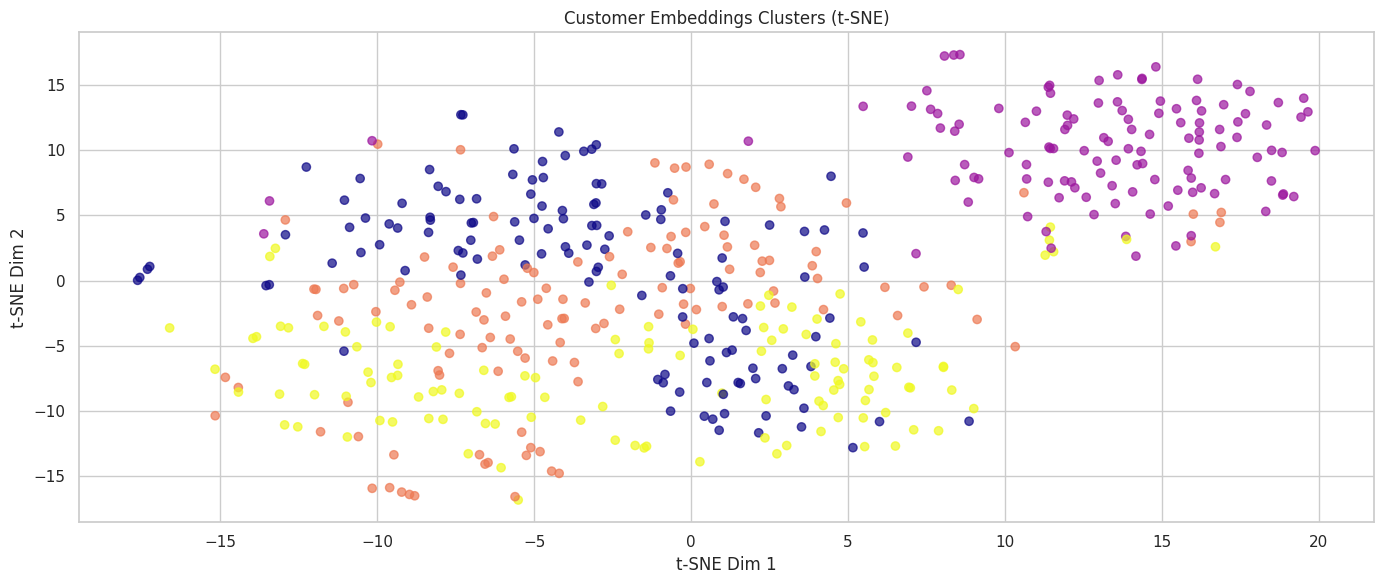

In [18]:
# 2. t-SNE on embeddings
# t-distributed Stochastic Neighbor Embedding reduces many dimensions into 2 plottable dimensions
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d = tsne.fit_transform(embeddings_array)

fig, axs = plt.subplots(1, 1, figsize=(14,6))
scatter = axs.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.7, c=cluster_labels_embed, cmap='plasma')
axs.set_title("Customer Embeddings Clusters (t-SNE)")
axs.set_xlabel("t-SNE Dim 1")
axs.set_ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.show()

**Verbally describe clusters**

In [21]:
cluster_summary = data.groupby('cluster_embedding')[features.columns].mean().round(1)
descriptions = []
for cluster_id, row in cluster_summary.iterrows():
    prompt = f"""
    This is the summary of a customer cluster:
    Grocery spend: {row.grocery_spend}
    Electronics spend: {row.electronics_spend}
    Clothing spend: {row.clothing_spend}
    Beauty spend: {row.beauty_spend}
    Visits per month: {row.visits_per_month}
    Average basket size: {row.avg_basket_size}

    What kind of shopper might this category describe?
    """
    # Write a title to classify the typical customer in this cluster in a maximum of 10 words.
    # Write a concise description of the typical customer in this cluster.

    response = co.chat(
        model='command-a-03-2025',
        message=prompt
    )
    descriptions.append(response.text)

for i, desc in enumerate(descriptions):
    print(f"Cluster {i}: {desc}")
    print()

Cluster 0: Based on the provided summary, this customer cluster appears to be a **high-spending, frequent, and diverse shopper** with a focus on a mix of essential and discretionary categories. Here’s a breakdown of the characteristics and the type of shopper this might describe:

1. **High Overall Spend**:  
   - The total spend across categories (Grocery, Electronics, Clothing, Beauty) is substantial, indicating a customer with significant purchasing power.  
   - **Electronics spend** is the highest, suggesting an interest in technology or high-value items.  

2. **Diverse Spending Habits**:  
   - The customer spends across multiple categories (Grocery, Electronics, Clothing, Beauty), indicating a broad range of interests and needs.  
   - This suggests a shopper who is not limited to one type of product but is willing to invest in various areas of their lifestyle.  

3. **Frequent Visits**:  
   - **5.6 visits per month** indicates a high level of engagement and loyalty to the sto